In [1]:
import os, sys
sys.path.append('..')
from os.path import abspath, dirname
import zarr
import z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from scipy import stats
from scipy.stats import skewnorm, lognorm
from scipy.optimize import minimize
import itertools
import seaborn as sns

from easi_fish import n5_metadata_utils as n5mu
from easi_fish import roi_prop, spot, intensity
import warnings
warnings.filterwarnings('ignore')

import importlib
importlib.reload(spot)
importlib.reload(roi_prop)
importlib.reload(intensity)

"""
Spot counts for cells with highly expressed genes (dense spots)
1. Measure total intensity of every ROI after bleed-through correction and background subtraction.
2. Calculate the number of spot from total intensity based on unit-spot intensity
3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 
   Spot count > cutoff: use spot count converted based on total fluorescence intensity; 
   Spot count < cutoff: use spot count from Airlocalize
"""

"\nSpot counts for cells with highly expressed genes (dense spots)\n1. Measure total intensity of every ROI after bleed-through correction and background subtraction.\n2. Calculate the number of spot from total intensity based on unit-spot intensity\n3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. \n   Spot count > cutoff: use spot count converted based on total fluorescence intensity; \n   Spot count < cutoff: use spot count from Airlocalize\n"

In [2]:
## input
input_dir = "D:\\SWAP\\Vincent\\lt171_FlpO\\gene_new_4tile\\outputs"
output_dir = os.path.join(input_dir, "testfull-aug9")  

# fixed image (directory - n5 format)
fix_dir = os.path.join(input_dir, "r2\\export_sigma3.n5")
# get appropriate image data within fix_dir
subpath='\\c3\\s2'

# registered image (directory - n5 format)
reg_dir = os.path.join(input_dir, "r1\\registration\\lt171_gene_4tile_r1-to-lt171_gene_4tile_r2\\warped")  

# segmentation mask (tif format accepted here)
lb_dir  = os.path.join(input_dir, "r2\\segmentation\\lt171_gene_4tile_r2-c3.tif" ) 

# spot dir 
spot_dir = os.path.join(input_dir, "spots_pooled") # pool spots together; warpped and fixed
intn_dir = os.path.join(input_dir, "intensities_pooled") # pool spots together; warpped and fixed
# for every gene
rounds = ['r1', 'r2']
channels = ['c0', 'c1', 'c2', 'c4']
# r1 should be the wrappped one
fx_spots = [os.path.join(spot_dir, f'spots_{r}_{c}.txt') 
                 for r, c in itertools.product(rounds, channels)]
fx_intns = [os.path.join(intn_dir, f'{r}_{c}_intensity.csv') 
                 for r, c in itertools.product(rounds, channels)]

for f in fx_spots:
    assert os.path.isfile(f)
for f in fx_intns:
    assert os.path.isfile(f)

## output
out_mask = os.path.join(output_dir, 'mask.tif')
out_badroi = os.path.join(output_dir, 'bad_roi_list.npy')
out_allroi = os.path.join(output_dir, "roi_all.csv") 
out_roi = os.path.join(output_dir, "roi.csv") 
out_spots = os.path.join(output_dir, "spotcount.csv")
out_spots_intn = os.path.join(output_dir, "spotcount_intn.csv")
# out_intensity = os.path.join(output_dir, "intensity_c0_r2.csv")
out_spots_merged = os.path.join(output_dir, 'spotcount_merged.csv')

In [3]:
lb=imread(lb_dir)
print(lb.shape)
roi = np.max(lb)
print(roi)

(1019, 915, 916)
13758


In [4]:
spots = np.loadtxt(fx_spots[0], delimiter=',')
print(spots.shape)
spots

(93393, 4)


array([[281.28497314,  64.55128479, -17.65543175, 242.22160339],
       [281.57122803,  62.67300797, -18.89440727, 172.60420227],
       [279.77487183,  61.80595779, -17.15635681, 148.51489258],
       ...,
       [360.24765015, 772.38494873, 836.57147217, 148.8513031 ],
       [281.8661499 , 790.39556885, 833.40368652, 193.94610596],
       [ 26.90949821, 806.92486572, 843.36090088, 129.95170593]])

# check spots range

In [8]:
print(np.nanmin(spots[:,0]), np.nanmax(spots[:,0]))
print(np.nanmin(spots[:,1]), np.nanmax(spots[:,1]))
print(np.nanmin(spots[:,2]), np.nanmax(spots[:,2]))

-81907.7578125 2327.73876953125
-4202.1796875 290801.21875
-38.324989318847656 483186.875


<AxesSubplot:>

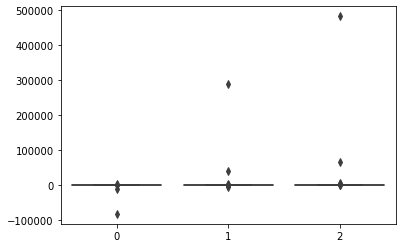

In [9]:
sns.boxplot(data=spots[:,:3])

<AxesSubplot:>

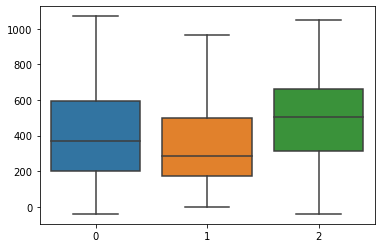

In [10]:
sns.boxplot(data=spots[:,:3], showfliers=False)

<AxesSubplot:>

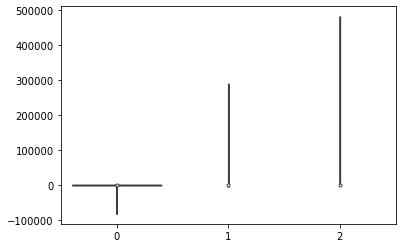

In [11]:
sns.violinplot(data=spots[:,:3], showfliers=False)

# test one channel

In [12]:
%%time
importlib.reload(spot)
spotcount = spot.spot_counts(lb, spots, verbose=False)
res0 = spotcount['spot count'] #.values

NaN found in line# 79374
CPU times: total: 19.3 s
Wall time: 19.3 s


In [13]:
%%time
importlib.reload(spot)
res = spot.spot_counts_worker(lb, spots)

removed 1 due to nan
91,005/93,393 spots in range (916, 915, 1019)
CPU times: total: 8.72 s
Wall time: 8.73 s


In [14]:
cond = (res == res0)
res[~cond], res0[~cond]

(7454     0.0
 8906     0.0
 9336     0.0
 10719    0.0
 11334    0.0
 dtype: float64,
 7454     1.0
 8906     1.0
 9336     1.0
 10719    1.0
 11334    2.0
 Name: spot count, dtype: float64)

In [15]:
# discrepany only happens at the edge
allroi = pd.read_csv(out_allroi).set_index('roi')
allroi.loc[~cond]

,Unnamed: 0,z,y,x,area
roi,,,,,
7454,7453,69.460319,322.778655,415.310720,1233.276744
8906,8905,16.707577,279.754103,417.413428,1535.885904
9336,9335,337.870954,234.278024,418.240753,680.048544
10719,10718,43.885966,114.280862,418.014097,869.879136
11334,11333,311.270627,246.029241,417.782138,592.776240


# test all channels
- only differences are on the edge

In [16]:
%%time
# apply to all channels
importlib.reload(spot)
resall = spot.spot_counts_v2(lb, spot_dir, s=[0.92,0.92,0.84], verbose=True)

Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c0.txt
removed 1 due to nan
91,005/93,393 spots in range (916, 915, 1019)
Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt
removed 7 due to nan
315,425/327,944 spots in range (916, 915, 1019)
Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c2.txt
removed 0 due to nan
36,062/36,786 spots in range (916, 915, 1019)
Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c4.txt
removed 1 due to nan
34,949/36,009 spots in range (916, 915, 1019)
Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r2_c0.txt
removed 0 due to nan
93,378/93,393 spots in range (916, 915, 1019)
Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r2_c1.txt
removed 0 due to nan
327,929/327,944 spots in range (916, 915, 1019)
Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r2_c2.txt

In [17]:
resall

,spots_r1_c0,spots_r1_c1,spots_r1_c2,spots_r1_c4,spots_r2_c0,spots_r2_c1,spots_r2_c2,spots_r2_c4
1,34.0,46.0,37.0,25.0,0.0,1.0,0.0,0.0
2,4.0,13.0,0.0,0.0,0.0,2.0,2.0,1.0
3,5.0,20.0,0.0,1.0,2.0,5.0,0.0,0.0
4,3.0,14.0,0.0,2.0,0.0,4.0,0.0,1.0
5,5.0,23.0,0.0,4.0,14.0,12.0,0.0,2.0
...,...,...,...,...,...,...,...,...
13754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13755,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0
13756,0.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0
13757,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [18]:
%%time
# apply to all channels
importlib.reload(spot)
resallv0 = spot.spot_counts(lb, spot_dir, s=[0.92,0.92,0.84], verbose=False)

Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c0.txt
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c0.txt line# 79374
Load: D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt line# 59548
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt line# 293582
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt line# 313383
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt line# 320791
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt line# 321804
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt line# 323138
NaN found in D:\SWAP\Vincent\lt171_FlpO\gene_new_4tile\outputs\spots_pooled\spots_r1_c1.txt line#

In [19]:
resallv0

,spots_r1_c0,spots_r1_c1,spots_r1_c2,spots_r1_c4,spots_r2_c0,spots_r2_c1,spots_r2_c2,spots_r2_c4
1,34.0,46.0,37.0,25.0,0.0,1.0,0.0,0.0
2,4.0,13.0,0.0,0.0,0.0,2.0,2.0,1.0
3,5.0,20.0,0.0,1.0,2.0,5.0,0.0,0.0
4,3.0,14.0,0.0,2.0,0.0,4.0,0.0,1.0
5,5.0,23.0,0.0,4.0,14.0,12.0,0.0,2.0
...,...,...,...,...,...,...,...,...
13754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13755,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0.0
13756,0.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0
13757,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [20]:
condall = resallv0 == resall
(~condall).sum()

spots_r1_c0     5
spots_r1_c1    27
spots_r1_c2     3
spots_r1_c4     2
spots_r2_c0     0
spots_r2_c1     1
spots_r2_c2     0
spots_r2_c4     0
dtype: int64

In [21]:
for col in condall:
    print(resallv0.loc[~condall[col], col] - resall.loc[~condall[col], col])
    print(allroi.loc[~condall[col]])

7454     1.0
8906     1.0
9336     1.0
10719    1.0
11334    2.0
Name: spots_r1_c0, dtype: float64
       Unnamed: 0           z           y           x         area
roi                                                               
7454         7453   69.460319  322.778655  415.310720  1233.276744
8906         8905   16.707577  279.754103  417.413428  1535.885904
9336         9335  337.870954  234.278024  418.240753   680.048544
10719       10718   43.885966  114.280862  418.014097   869.879136
11334       11333  311.270627  246.029241  417.782138   592.776240
1296     6.0
4011     2.0
6010     1.0
6021     1.0
8853     1.0
8906     3.0
8910     1.0
9336     2.0
10101    1.0
10380    1.0
10719    3.0
10916    1.0
11250    3.0
11334    3.0
11570    1.0
11589    3.0
11705    1.0
11955    1.0
12079    1.0
12187    1.0
12438    1.0
12491    1.0
12829    1.0
12845    3.0
13119    2.0
13207    1.0
13335    1.0
Name: spots_r1_c1, dtype: float64
       Unnamed: 0           z           y      